In [1]:
import os
import numpy as np
from ete3 import Tree

class TreeEncoder:

    def encode_tree(self, tree_str):
        """
        Encode the tree structure into a format suitable for input into the neural network.
        """
        # Check if the tree is already encoded
        csv_file = tree_str[:-4] + '.csv'
        if os.path.exists(csv_file):
            return csv_file
        # Call the external script to get CDV encoding
        cmd = f"python -m CDV_full_tree -t {tree_str} > {tree_str[:-4]}.csv"
        os.system(cmd)

    def encode_all_trees(self, trees_directory):
        """
        Encode all the trees in the given directory.
        """
        tree_files = [os.path.join(trees_directory, file) for file in os.listdir(trees_directory) if file.endswith('.nwk')]
        for tree_file in tree_files:
            print(tree_file)
            self.encode_tree(tree_file)


In [2]:
trees_directory = "trees/"
encoder = TreeEncoder()
encoded_trees = encoder.encode_all_trees(trees_directory)

trees/bd.nwk
trees/bisse.nwk
trees/bisseness.nwk
trees/classe.nwk
trees/geosse.nwk
trees/musse.nwk


In [76]:
import pandas as pd

# Load parameter values as a dataframe
tree_files = [os.path.join(trees_directory, file) for file in os.listdir(trees_directory) if file.endswith('.nwk')]

column_names = ['lambda1', 'lambda2', 'lambda3', 'mu1', 'mu2', 'mu3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']

def process_params_musse(param_file):
    # Reads the parameter file and saves the values in a csv file, one tree per row.
    '''
    Example:
    num_states 3
    lambda1  0.581637403143104
    lambda2  0.639469627428334
    lambda3  0.694642654564232
    mu1  0.076379950507544
    mu2  0.339707092673052
    mu3  0.246268530318048
    q12  0.191004574298859
    q13  0.143894099444151  
    q21  0.154783235490322
    q23  0.62774416487664
    q31  0.460761926881969
    q32  0.606042030081153
    num_states 3
    ....
    '''
    # If the parameter file is already in the csv format, return
    if param_file.endswith('.csv'):
        return
    with open(param_file, 'r') as f:
        lines = f.readlines()
    param_values = []
    for line in lines:
        if line.startswith('num_states'):
            param_values.append([])
        else:
            param_values[-1].append(line.split()[1])
    param_df = pd.DataFrame(param_values)
    param_df.to_csv(param_file + '.csv', sep='\t', header=False, index=False)
        
        
    

# Create a dataframe to store the parameter values

process_params_musse(param_file=trees_directory + 'musse.params')

cutoff = 0.8  # Number of train trees

param = pd.read_csv(trees_directory + 'musse.params.csv', sep='\t', header=None)

cutoff = int(cutoff * param.shape[0])

param_train = param.iloc[:cutoff, :]
param_test = param.iloc[cutoff:, :]

# Check that the number of columns is correct
assert param_train.shape[1] == 12


print(param_train.shape)
print(param_test.shape)



def rename_columns(df, names):
    df = df.rename(columns={i: names[i] for i in df.columns})
    return df

param_train = rename_columns(param_train, column_names)
param_test = rename_columns(param_test, column_names)

# loading tree encodings/representations
# encoding has the following structure: 1 value of tree height, 500 values for tip states ('1' or '2')
# 1 value for tree height and 500 values for internal node heights
# + 2 values for nb of tips of each type (to be removed) and 1 value of rescaling (removed, but stocked for rescaling predicted values back to the original scale)

# split the encoding into train and test (cutoff is 0.8% of the data)

encoding = pd.read_csv(trees_directory + 'musse.csv', sep="\t", header=None, index_col=0, skiprows=1)

encoding_train = encoding.iloc[:cutoff, :]
encoding_test = encoding.iloc[cutoff:, :]

print(encoding_train.shape)
print(encoding_test.shape)



# make sure there is correspondance between indexes of dataframe with parameter values and encodings
encoding_train.index = param_train.index
encoding_test.index = param_test.index


# part of the relative path for writing down the output files
chemin = './trained_models/musse'

# the suffix of output files
expname='_236_longest_known_nb_tips_absolute_error'

# check
param_test

# check
print(encoding_test.shape)
print(param_train)

# check
encoding_test

(188, 12)
(48, 12)
(188, 502)
(48, 502)
(48, 502)
      lambda1   lambda2   lambda3       mu1       mu2       mu3       q12  \
0    0.581637  0.639470  0.694643  0.076380  0.339707  0.246269  0.191005   
1    0.171136  0.455613  0.551331  0.150403  0.076921  0.364527  0.860820   
2    0.587373  0.688031  0.478535  0.045761  0.677784  0.630738  0.375229   
3    0.267792  0.690626  0.640356  0.712357  0.443546  0.298779  0.660996   
4    0.454680  0.469158  0.566001  0.275795  0.631396  0.581336  0.173862   
..        ...       ...       ...       ...       ...       ...       ...   
183  0.399402  0.648075  0.359147  0.174653  0.618361  0.579190  0.208604   
184  0.667684  0.585739  0.564760  0.507742  0.060224  0.121202  0.861186   
185  0.178054  0.480676  0.506795  0.174320  0.173302  0.183125  0.483931   
186  0.562295  0.394653  0.394171  0.213037  0.562627  0.219360  0.539239   
187  0.537659  0.462445  0.229084  0.032727  0.520438  0.293538  0.434546   

          q13       q21  

,1,2,3,4,5,6,7,8,9,10,...,493,494,495,496,497,498,499,500,501,502
188,8.676471,8.145612,7.405578,8.574098,6.189696,8.410589,5.527042,8.344064,3.906218,8.001198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984692
189,5.566919,3.304488,2.085149,3.614885,5.369089,5.548139,3.587705,1.914676,3.832770,4.811342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.057625
190,6.756629,5.837831,5.360019,6.300811,4.592506,6.134076,4.401692,4.111634,5.837400,5.492262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.285546
191,8.591858,8.299559,8.128529,8.250546,8.536912,8.009889,7.675564,8.069486,7.090179,6.023620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.510667
192,6.241299,4.961013,3.887486,2.785038,5.709429,2.255027,4.953132,4.706396,5.161895,6.164427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.911286
193,7.264057,6.123328,6.922575,7.102495,5.656140,4.588508,6.216218,4.155958,6.550720,6.194308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.725066
194,6.936124,5.608161,6.569588,5.048099,6.293431,4.921608,5.844405,6.906264,4.424493,4.040329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.371666
195,9.460591,0.511083,8.636418,9.080660,8.286598,9.303565,8.148791,5.699310,8.545024,6.897056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.539612
196,6.236038,5.422835,5.910574,4.307930,5.920291,4.643962,5.985254,4.269156,4.096497,5.409414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.235421
197,8.981021,7.614126,7.477070,7.340090,7.813267,7.285035,7.269209,8.710808,8.518363,8.238404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.933735


In [77]:
'''
#correctly reshape parameters (rescaling) and encodings (remove nb of each type + rescale factor):

### TRAINING SET: PARAMETER VALUES
# rescaling factor
param_train['norm_factor'] = encoding_train[502]
print(param_train['norm_factor'])
# rescale target values according to scaling factor
param_train['net_rat1_rescaled'] = param_train['net_rate1']*param_train['norm_factor']
param_train['net_rat2_rescaled'] = param_train['net_rate2']*param_train['norm_factor']
param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
param_train['q01_rescaled'] = param_train['q01']*param_train['norm_factor']

### TESTING SET: PARAMETER VALUES
# rescaling factor
param_test['norm_factor'] = encoding_test[1005]
# rescale target values
param_test['net_rat1_rescaled'] = param_test['net_rate1']*param_test['norm_factor']
param_test['net_rat2_rescaled'] = param_test['net_rate2']*param_test['norm_factor']
param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
param_test['q01_rescaled'] = param_test['q01']*param_test['norm_factor']

# remove irrelevant columns: count of each type of tip and normalization factor
encoding_train.drop(columns=[1003, 1004, 1005], axis=1, inplace=True)
encoding_test.drop(columns=[1003, 1004, 1005], axis=1, inplace=True)
'''

"\n#correctly reshape parameters (rescaling) and encodings (remove nb of each type + rescale factor):\n\n### TRAINING SET: PARAMETER VALUES\n# rescaling factor\nparam_train['norm_factor'] = encoding_train[502]\nprint(param_train['norm_factor'])\n# rescale target values according to scaling factor\nparam_train['net_rat1_rescaled'] = param_train['net_rate1']*param_train['norm_factor']\nparam_train['net_rat2_rescaled'] = param_train['net_rate2']*param_train['norm_factor']\nparam_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']\nparam_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']\nparam_train['q01_rescaled'] = param_train['q01']*param_train['norm_factor']\n\n### TESTING SET: PARAMETER VALUES\n# rescaling factor\nparam_test['norm_factor'] = encoding_test[1005]\n# rescale target values\nparam_test['net_rat1_rescaled'] = param_test['net_rate1']*param_test['norm_factor']\nparam_test['net_rat2_rescaled'] = param_test['net_rate2']*para

In [78]:
encoding_train.shape
# Write to csv
param_train.to_csv(chemin + '/param_train' + expname + '.csv')
param_test.to_csv(chemin + '/param_test' + expname + '.csv')
encoding_train.to_csv(chemin + '/encoding_train' + expname + '.csv')
encoding_test.to_csv(chemin + '/encoding_test' + expname + '.csv')

In [79]:
# Read the data
param_train = pd.read_csv(chemin + '/param_train' + expname + '.csv', index_col=0)
param_test = pd.read_csv(chemin + '/param_test' + expname + '.csv', index_col=0)
encoding_train = pd.read_csv(chemin + '/encoding_train' + expname + '.csv', index_col=0)
encoding_test = pd.read_csv(chemin + '/encoding_test' + expname + '.csv', index_col=0)



#Choice of the parameters to predict

predict_all = True
if not predict_all:
    target1 = 'lambda1'
    target2 = 'lambda2'
    target3 = 'lambda3'
    target4 = 'mu1'
    target5 = 'mu2'
    target6 = 'mu3'
    target7 = 'q12'
    target8 = 'q13'
    target9 = 'q21'
    target10 = 'q23'
    target11 = 'q31'
    target12 = 'q32'
    
    targets = pd.DataFrame(param_train[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12])
    targets_test = pd.DataFrame(param_test[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12])
    
else:
    
    targets = param_train
    targets_test = param_test
    
features = encoding_train
features_test = encoding_test

# how large is the validation set
valid_set_nb = 100
valid_frac = valid_set_nb/features.shape[0]
train_size_frac = (features.shape[0]-valid_set_nb)/features.shape[0]

In [80]:
    """
    #Add the known sampling fraction as 3*2 matrix into the representation (both train and test sets)
    add_target = "sampling_frac"
    added_targets = pd.DataFrame(param_train[add_target])
    features['1003'] = added_targets
    features['1004'] = added_targets
    features['1005'] = added_targets
    features['1006'] = added_targets
    features['1007'] = added_targets
    features['1008'] = added_targets

    added_targets2 = pd.DataFrame(param_test[add_target])
    features_test['1003'] = added_targets2
    features_test['1004'] = added_targets2
    features_test['1005'] = added_targets2
    features_test['1006'] = added_targets2
    features_test['1007'] = added_targets2
    features_test['1008'] = added_targets2
    """

'\n#Add the known sampling fraction as 3*2 matrix into the representation (both train and test sets)\nadd_target = "sampling_frac"\nadded_targets = pd.DataFrame(param_train[add_target])\nfeatures[\'1003\'] = added_targets\nfeatures[\'1004\'] = added_targets\nfeatures[\'1005\'] = added_targets\nfeatures[\'1006\'] = added_targets\nfeatures[\'1007\'] = added_targets\nfeatures[\'1008\'] = added_targets\n\nadded_targets2 = pd.DataFrame(param_test[add_target])\nfeatures_test[\'1003\'] = added_targets2\nfeatures_test[\'1004\'] = added_targets2\nfeatures_test[\'1005\'] = added_targets2\nfeatures_test[\'1006\'] = added_targets2\nfeatures_test[\'1007\'] = added_targets2\nfeatures_test[\'1008\'] = added_targets2\n'

In [81]:
# explore the data
print(features.shape)
print(targets.shape)
print(features_test.shape)

(188, 502)
(188, 12)
(48, 502)


In [82]:
#Standardization of the input features: done for summary statistics
"""
scale = StandardScaler()
features = scale.fit_transform(features)
features_test = scale.transform(features_test)
"""

X = features
Y = targets

Y_test = targets_test
X_test = features_test

In [83]:
X_test

,1,2,3,4,5,6,7,8,9,10,...,493,494,495,496,497,498,499,500,501,502
188,8.676471,8.145612,7.405578,8.574098,6.189696,8.410589,5.527042,8.344064,3.906218,8.001198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984692
189,5.566919,3.304488,2.085149,3.614885,5.369089,5.548139,3.587705,1.914676,3.832770,4.811342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.057625
190,6.756629,5.837831,5.360019,6.300811,4.592506,6.134076,4.401692,4.111634,5.837400,5.492262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.285546
191,8.591858,8.299559,8.128529,8.250546,8.536912,8.009889,7.675564,8.069486,7.090179,6.023620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.510667
192,6.241299,4.961013,3.887486,2.785038,5.709429,2.255027,4.953132,4.706396,5.161895,6.164427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.911286
193,7.264057,6.123328,6.922575,7.102495,5.656140,4.588508,6.216218,4.155958,6.550720,6.194308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.725066
194,6.936124,5.608161,6.569588,5.048099,6.293431,4.921608,5.844405,6.906264,4.424493,4.040329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.371666
195,9.460591,0.511083,8.636418,9.080660,8.286598,9.303565,8.148791,5.699310,8.545024,6.897056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.539612
196,6.236038,5.422835,5.910574,4.307930,5.920291,4.643962,5.985254,4.269156,4.096497,5.409414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.235421
197,8.981021,7.614126,7.477070,7.340090,7.813267,7.285035,7.269209,8.710808,8.518363,8.238404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.933735


In [84]:
print(features.shape)

(188, 502)


In [85]:
#Creation of the Network Model: model definition

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D

def build_model():
    model = Sequential()
    
    model.add(keras.layers.Reshape((X.shape[1]//2, 2), input_shape=(X.shape[1],))) # the input of 1008 columns is reshaped into 504*2 (one column for tip states, the other for internal nodes distances + repeated value of tree height + 3*sampling fraction)
    # convolutional part
    model.add(Conv1D(filters = 50, kernel_size=(5), input_shape= (504, 2), activation='elu'))
    model.add(Conv1D(filters = 50, kernel_size=(10), activation='elu'))
    model.add(MaxPooling1D(10))
    model.add(Conv1D(filters = 80, kernel_size=(10), activation='elu'))
    # flattening the 2D 'feature maps' into 1D vector used in 'FFNN part'
    model.add(GlobalAveragePooling1D())
    # FFNN part
    keras.layers.Dropout(0.5)
    model.add(Dense(64, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(32, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(16, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(12, activation='elu'))
    # show the model structure
    model.summary()
    return model

In [86]:
#Building of the model

from keras import losses

#model initiation
estimator = build_model()

#Adam optimizer, loss measure: mean absolute error, metrics measured: MAPE
estimator.compile(loss='mae', optimizer = 'Adam', metrics=[losses.mean_absolute_percentage_error])

#early stopping to avoid overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

#display training progress for each completed epoch.
class PrintD(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# maximum number of EPOCHS, ie full training cycles on the whole training dataset (how many times we see the same training set)
EPOCHS = 10000

#Training of the Network, with an independent validation set
history = estimator.fit(X, Y, verbose = 1, epochs=EPOCHS, validation_split=valid_frac, batch_size=8000, callbacks=[early_stop, PrintD()])



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 251, 2)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 247, 50)           550       
                                                                 
 conv1d_10 (Conv1D)          (None, 238, 50)           25050     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 23, 50)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 14, 80)            40080     
                                                                 
 global_average_pooling1d_3   (None, 80)               0         
 (GlobalAveragePooling1D)                             

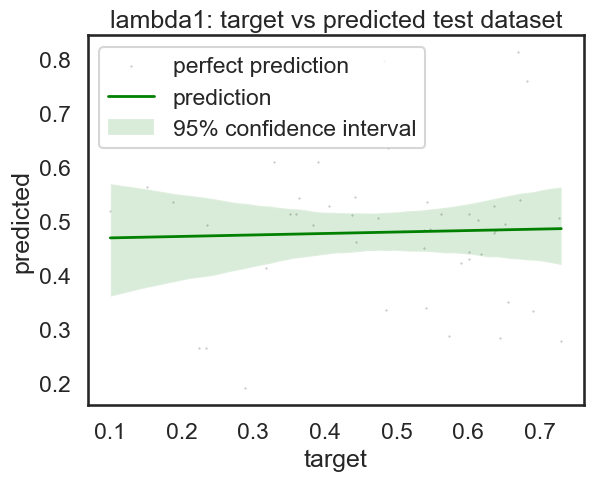

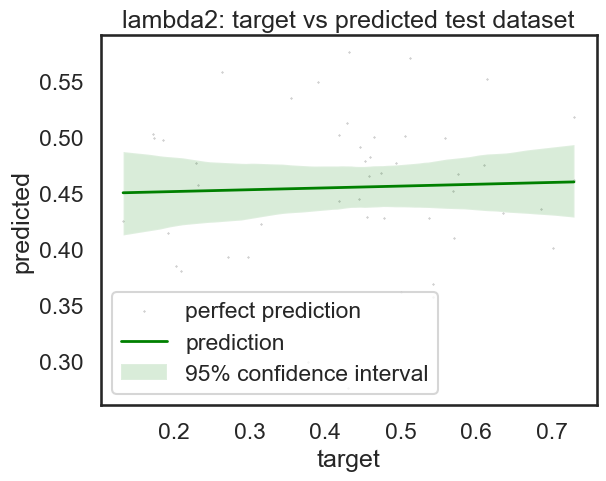

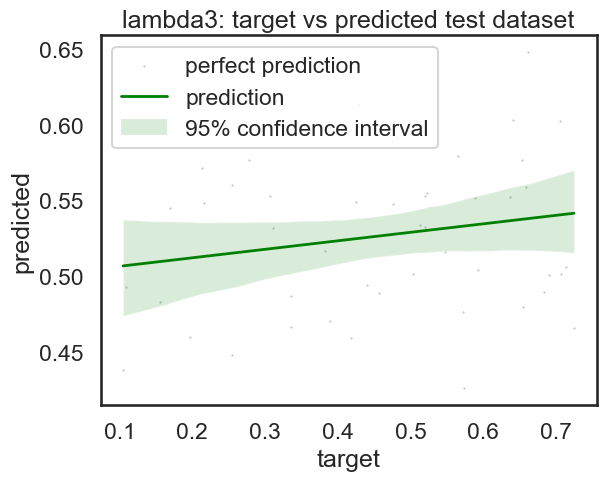

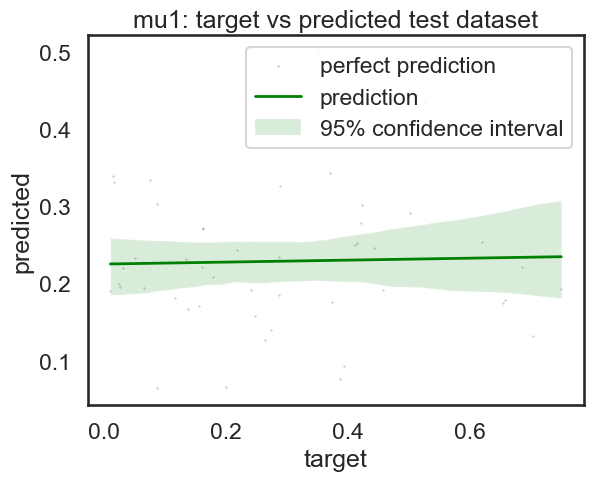

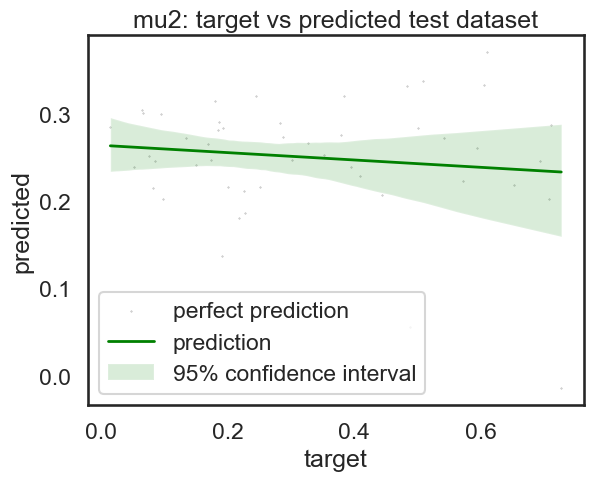

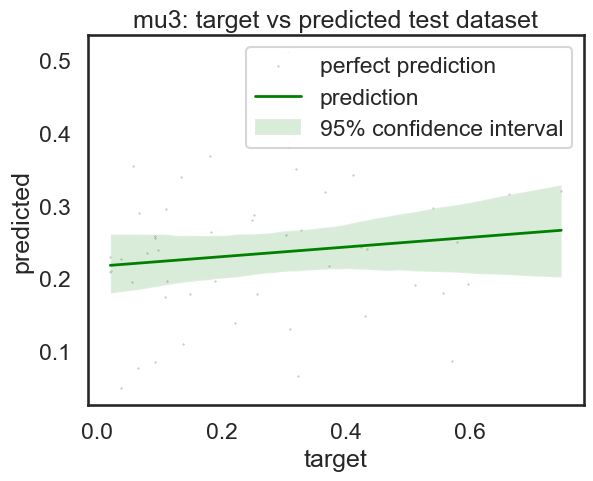

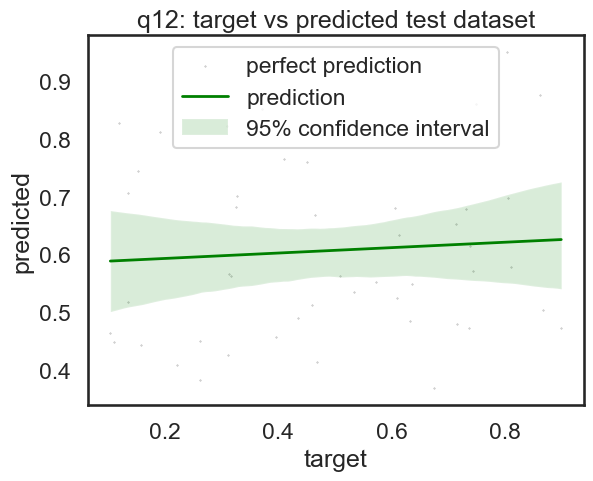

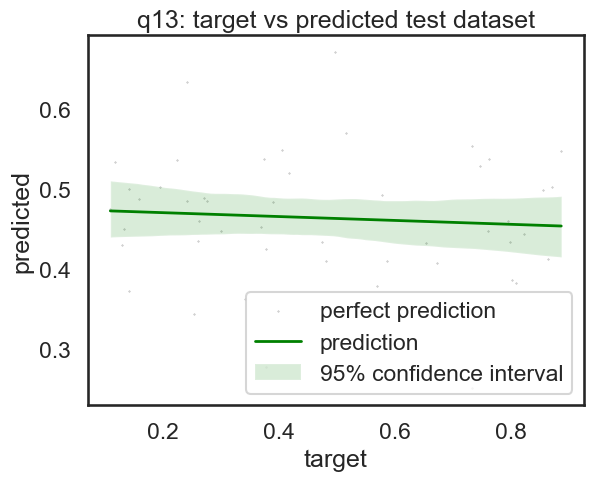

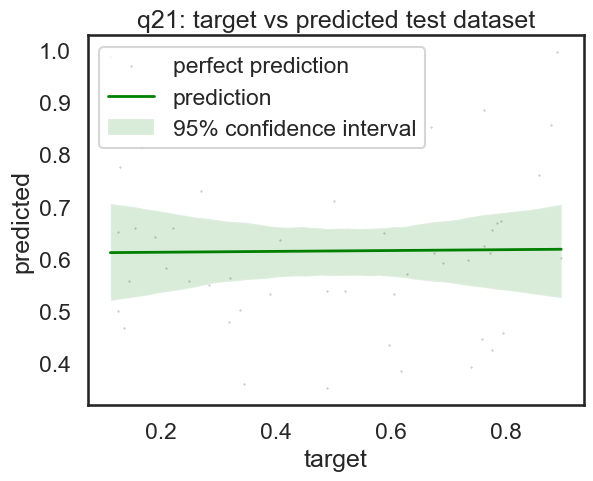

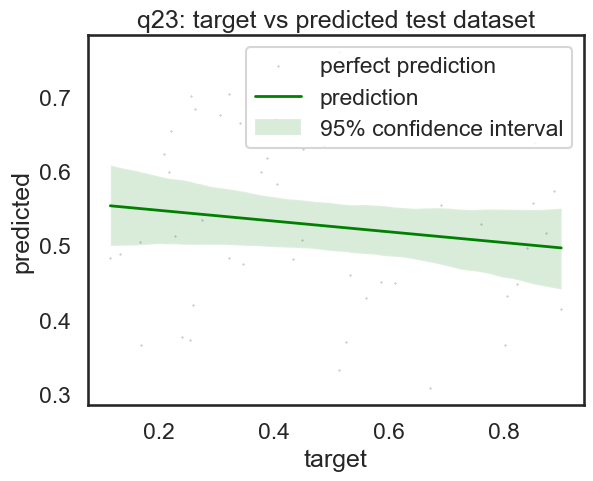

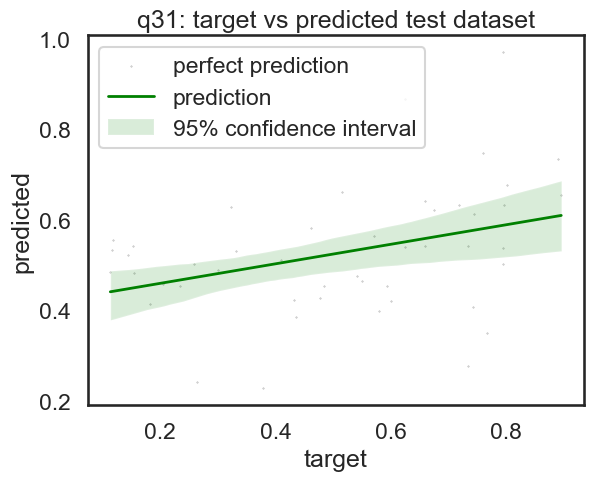

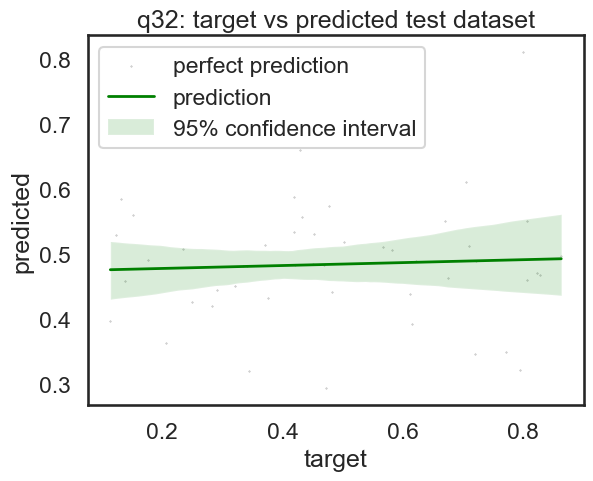

In [87]:
import seaborn as sns
#import statsmodel.formula.api as smf
import matplotlib.pyplot as plt

#Plot test vs predicted
# predict values for the test set
predicted_test = pd.DataFrame(estimator.predict(X_test))
predicted_test.columns = Y_test.columns # rename correctly the columns
predicted_test.index = Y_test.index # rename indexes for correspondence

elts = []

# just for subsetting columns more automatically + naming output plots
for elt in Y_test.columns:
    elts.append(elt)

for elt in elts:
    sub_df = pd.DataFrame({'predicted_minus_target_' + elt: predicted_test[elt] - Y_test[elt], 'target_'+elt: Y_test[elt], 'predicted_'+elt: predicted_test[elt]})
    if elt == elts[0]:
        df = sub_df
    else:
        sub_df.index = df.index
        df = pd.concat([df, sub_df], axis=1)

# fast plotting for analysis (with seaborn):
def target_vs_predicted(target_name, predicted_name, param_name, file_name_beg) : 
    sns.set_style('white')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=predicted_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':2})
    plt.title(param_name + ': target vs predicted test dataset')
    plt.xlabel('target')
    plt.ylabel('predicted')
    innerlimit = min(df[target_name])
    
    outerlimit = max(df[target_name])
    #plt.plot([innerlimit, outerlimit], [innerlimit, outerlimit], linewidth=2, color='red')
    plt.legend(['perfect prediction', 'prediction', '95% confidence interval'])
    plt.show()
    return None

    
for elt in elts:
    target_vs_predicted('target_'+elt, 'predicted_'+elt, elt, file_name_beg=elt)

In [88]:
# table with statistics on errors
errors_index = elts
errors_columns = ['MAE', 'RMSE', 'RME']
errors = pd.DataFrame(index=errors_index, columns=errors_columns)

def get_mae_rmse(name_var):
    predicted_vals = df['predicted_' + name_var]
    target_vals = df['target_' + name_var]
    diffs_abs = abs(target_vals - predicted_vals)
    diffs_rel = diffs_abs/target_vals
    diffs_abs_squared = diffs_abs**2
    mae = np.sum(diffs_abs)/len(diffs_abs)
    rmse = np.sqrt(sum(diffs_abs_squared)/len(diffs_abs_squared))
    rme = np.sum(diffs_rel)/len(diffs_rel)
    return mae, rmse, rme
    

#errors.loc['R_nought'] = np.array(get_mae_rmse('R_nought'))
for elt in errors_index:
    errors.loc[elt] = np.array(get_mae_rmse(elt))

print(errors)

              MAE      RMSE       RME
lambda1  0.167457  0.201832  0.471709
lambda2  0.137857  0.168388  0.452168
lambda3  0.149662  0.185599  0.558994
mu1      0.182429  0.231034   2.18788
mu2      0.182783  0.236862  1.146337
mu3      0.164486  0.204025  1.412727
q12      0.237755  0.299109  0.948472
q13      0.239333  0.269475  0.776263
q21      0.256969  0.320946  1.113398
q23      0.254018  0.280837  0.761983
q31      0.190469  0.228155  0.697075
q32      0.195482   0.23413  0.630713


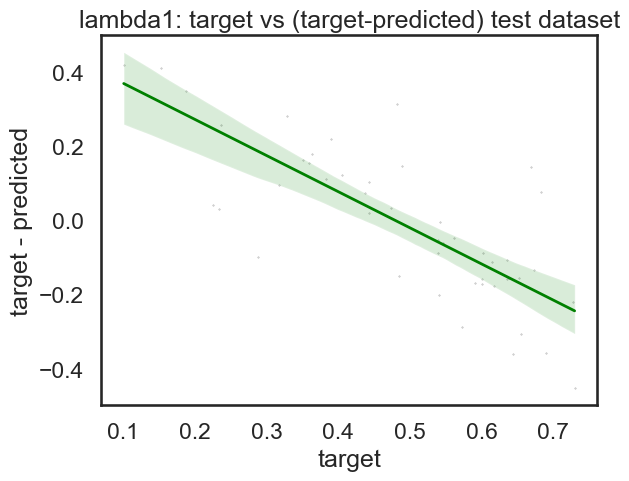

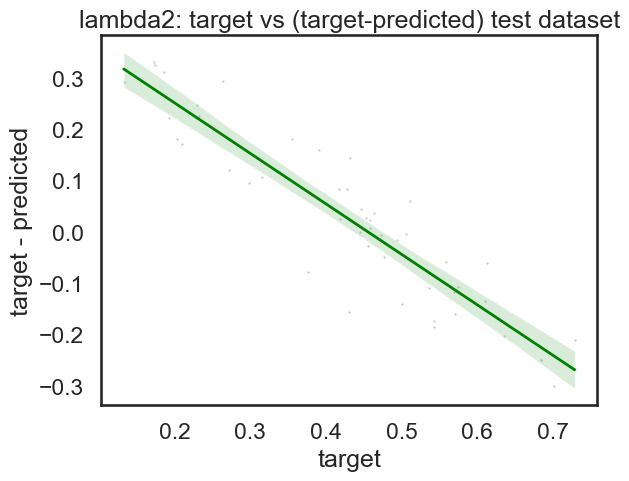

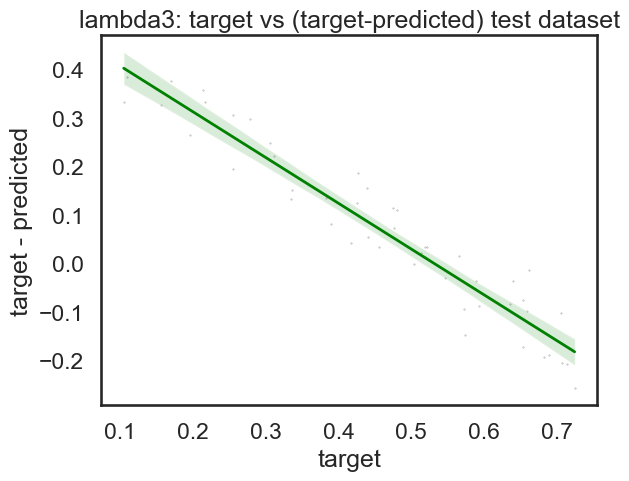

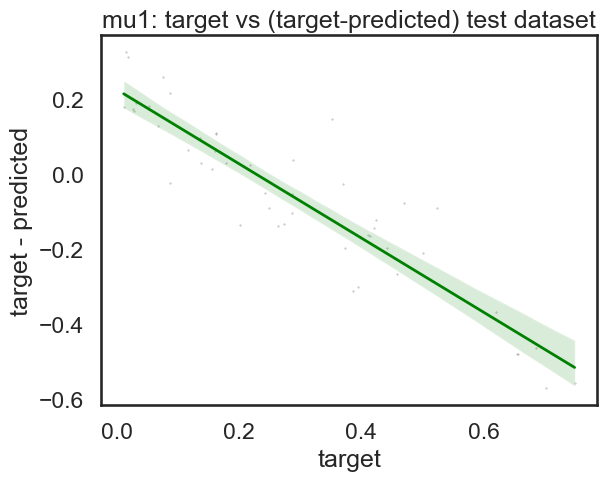

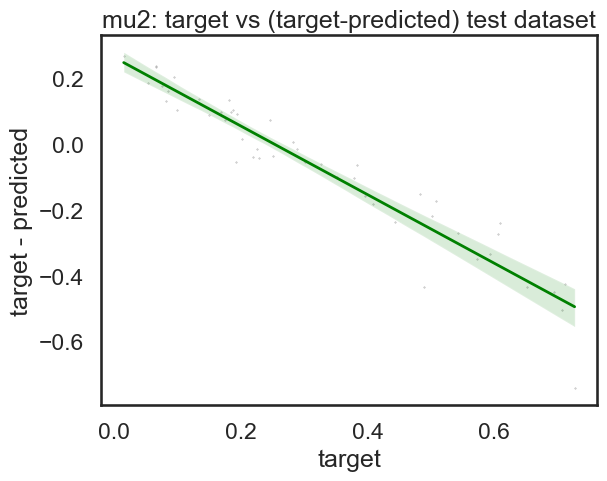

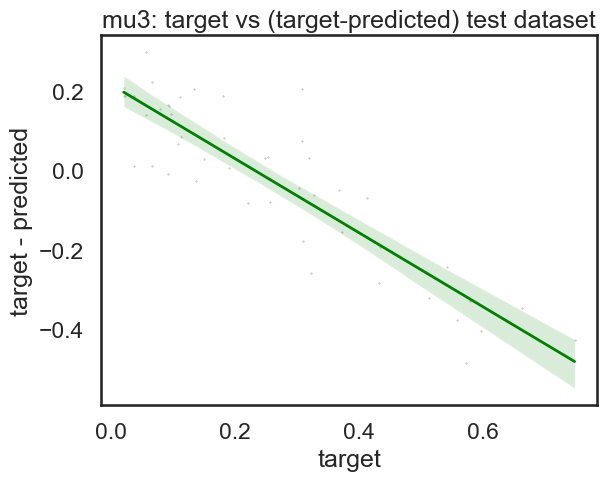

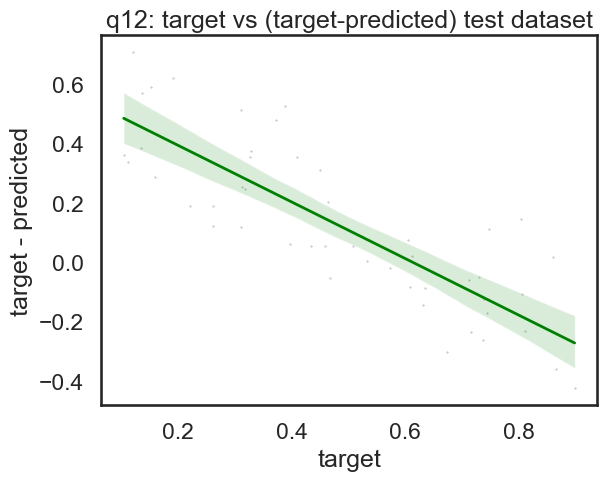

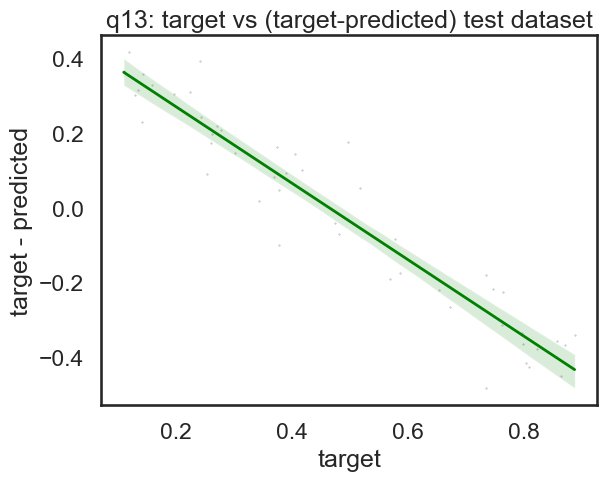

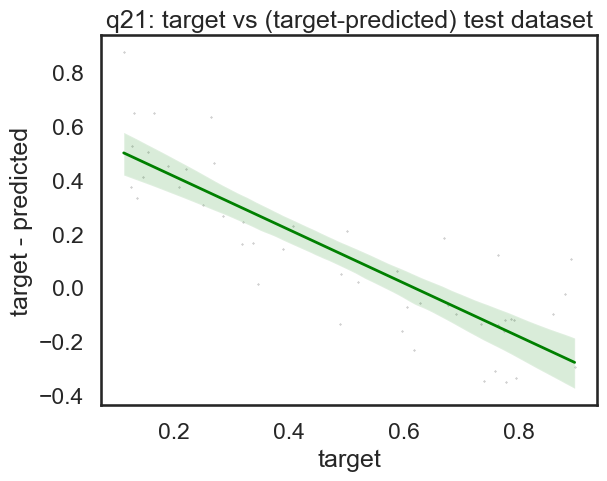

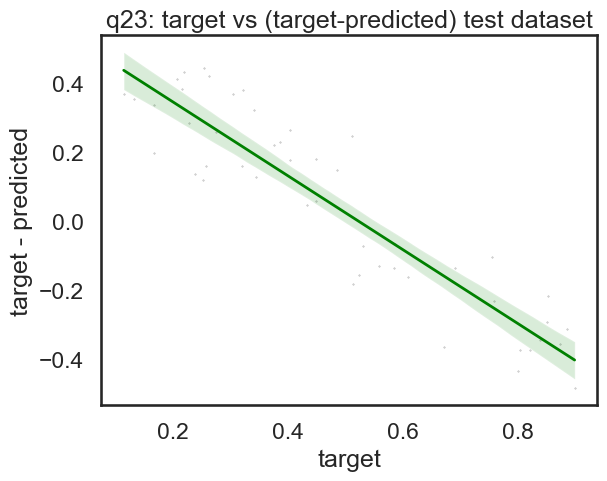

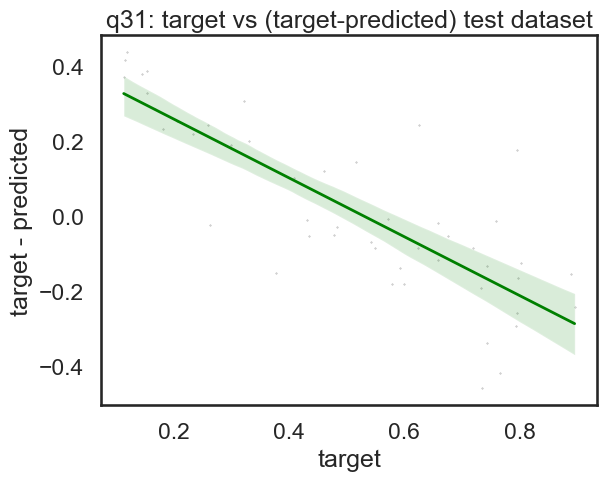

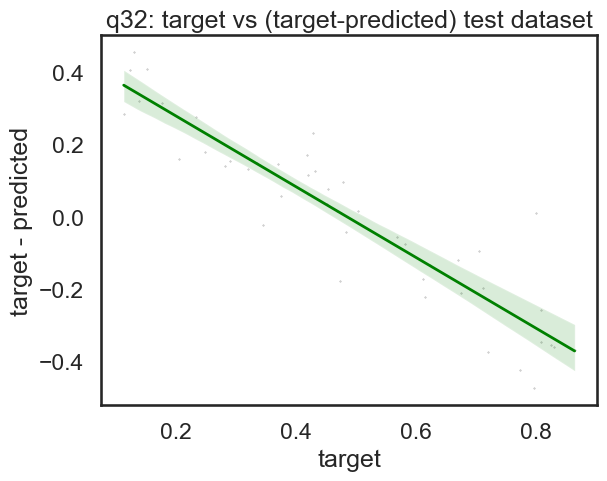

In [89]:
#print differences between predicted and target as function of target: showing structural bias

def predicted_minus_target_vs_target(pr_m_tar_name, target_name, param_name, file_name_beg) : 
    sns.set_style('white')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=pr_m_tar_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':2})
    plt.title(param_name + ': target vs (target-predicted) test dataset')
    plt.xlabel('target')
    plt.ylabel('target - predicted')
    innerlimit = min(df[target_name])
    
    outerlimit = max(df[target_name])
    
    #plt.plot([innerlimit, outerlimit], [0, 0], linewidth=2, color='red')
    plt.show()
    return None


for elt in elts:
    predicted_minus_target_vs_target('predicted_minus_target_'+elt, 'target_'+elt, elt, file_name_beg=elt)


In [90]:
#measure of correlation: predicted vs target
from scipy.stats import spearmanr, pearsonr

from sklearn.metrics import r2_score

pearson_cors = []

for elt in elts:
    pearson_cors.append(pearsonr(Y_test[elt], predicted_test[elt])[0])

print("Global pearson correlation between predicted and effective parameter: ", Y_test.columns, pearson_cors)


Global pearson correlation between predicted and effective parameter:  Index(['lambda1', 'lambda2', 'lambda3', 'mu1', 'mu2', 'mu3', 'q12', 'q13',
       'q21', 'q23', 'q31', 'q32'],
      dtype='object') [0.03457215780120801, 0.03929156458187621, 0.19521765979292852, 0.029478187896331026, -0.13067028247800602, 0.1398391264287065, 0.0719789528352093, -0.07800010016465567, 0.013726338156373863, -0.1543193706825149, 0.36993297828078775, 0.05506315484911552]


In [91]:
###save the model, weights (and scaler for sumstats only)

from keras.models import model_from_json

# save model
model_trial_1000 = estimator.to_json()
with open(chemin + '/model_all' + expname + '.json','w') as json_file:
    json_file.write(model_trial_1000)

# save weights
estimator.save_weights(chemin + '/model_all_weights' + expname +'.h5')
print('model saved!')

'''
#load the model
json_file = open('../Model/' + chemin + 'model_all' + expname + '.json', 'r')
loaded_file = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_file)
#load weights
loaded_model.load_weights(../Model/' + chemin + 'model_all_weights' + expname +'.h5'5)
print('model loaded!')

'''

#save scaler when there is one (FFNN-SS)
"""
from sklearn.externals import joblib

scale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'
joblib.dump(scale, scale_filename)

print('scale saved!')
#load scaler:
#scale = joblib.load(scale_filename)
"""


model saved!


"\nfrom sklearn.externals import joblib\n\nscale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'\njoblib.dump(scale, scale_filename)\n\nprint('scale saved!')\n#load scaler:\n#scale = joblib.load(scale_filename)\n"

In [92]:
####save the predicted and the target dataframes

Y_test.to_csv(chemin + expname + 'target_all.csv', header=True)

predicted_test.to_csv(chemin + expname + 'predicted_all.csv', header=True)